In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import requests
import seaborn as sns

# Load and Prepare Data

In [2]:
df = pd.read_csv("../Data/MetObjects.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            484956 non-null  object 
 1   Is Highlight             484956 non-null  bool   
 2   Is Timeline Work         484956 non-null  bool   
 3   Is Public Domain         484956 non-null  bool   
 4   Object ID                484956 non-null  int64  
 5   Gallery Number           49541 non-null   object 
 6   Department               484956 non-null  object 
 7   AccessionYear            481094 non-null  object 
 8   Object Name              482690 non-null  object 
 9   Title                    456153 non-null  object 
 10  Culture                  208190 non-null  object 
 11  Period                   91143 non-null   object 
 12  Dynasty                  23201 non-null   object 
 13  Reign                    11236 non-null   object 
 14  Port

In [6]:
def clean_culture(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

df["culture_clean"] = df["Culture"].fillna("").apply(clean_culture)

In [7]:

vectorizer = TfidfVectorizer(stop_words="english", min_df=2)
X = vectorizer.fit_transform(df["culture_clean"])

nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:][::-1]]))

Topic #1:
american european probably market british chinese native shaker possibly japanese
Topic #2:
french paris british probably svres possibly italian german rouen limoges
Topic #3:
greek attic italian south laconian roman apulian corinthian cypriot east
Topic #4:
japan ryky islands shiga korea ainu france probably possibly europe
Topic #5:
china north northwest northeast turkestan xinjiang autonomous region asia central


In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

df["culture_cluster"] = labels

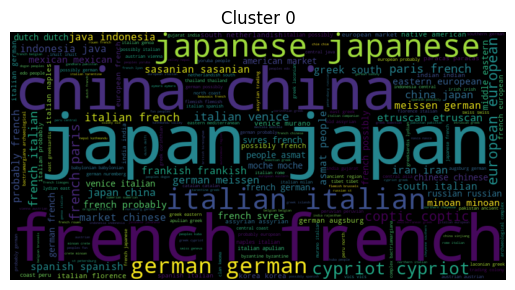

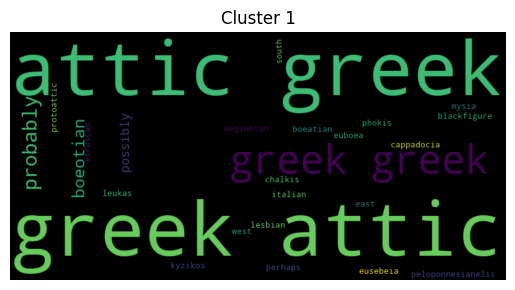

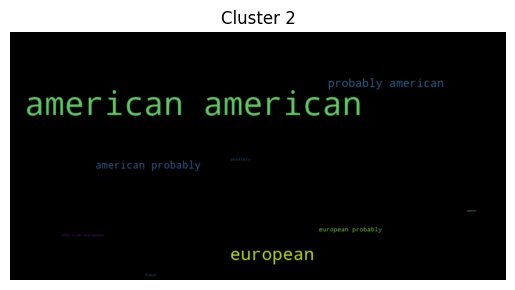

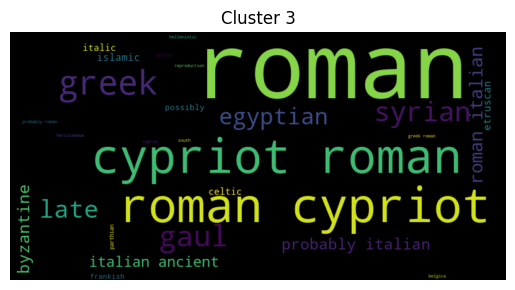

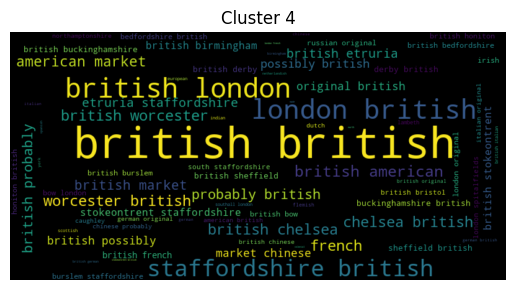

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i in range(5):
    text = " ".join(df[df["culture_cluster"] == i]["culture_clean"])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {i}")
    plt.show()

# Incorporate Other Data Sources

In [11]:
def fetch_artic_data(limit=5000):
    base_url = "https://api.artic.edu/api/v1/artworks"
    params = {
        "fields": "id,title",
        "limit": 100,
        "page": 1
    }

    results = []
    while len(results) < limit:
        response = requests.get(base_url, params=params)
        data = response.json()["data"]
        results.extend(data)
        params["page"] += 1
        if not data:
            break  # no more data

    df = pd.DataFrame(results)
    df["source"] = "Chicago"
    return df.head(limit)

df_chicago = fetch_artic_data()

In [12]:
df_chicago

,id,title,source
0,7988,Claude Monet,Chicago
1,161,Skyphos (Drinking Cup),Chicago
2,22,"Villa Pamphili outside Porta S. Pancrazio, fro...",Chicago
3,9637,View of an Italian Villa and Gardens (the Belv...,Chicago
4,15854,Seated Female Nude,Chicago
...,...,...,...
4995,247989,"Sears (Willis) Tower, Chicago, Illinois, Eleva...",Chicago
4996,247988,"Sears (Willis) Tower, Chicago, Illinois, Eleva...",Chicago
4997,247987,"Sears (Willis) Tower, Chicago, Illinois, Eleva...",Chicago
4998,247985,"Sears (Willis) Tower, Chicago, Illinois, Eleva...",Chicago


In [13]:
def fetch_cleveland_data(limit=5000):
    base_url = "https://openaccess-api.clevelandart.org/api/artworks/"
    params = {
        "limit": 100,
        "skip": 0
    }

    results = []
    while len(results) < limit:
        response = requests.get(base_url, params=params)
        data = response.json()["data"]
        for item in data:
            results.append({
                "id": item.get("id"),
                "title": item.get("title"),
            })
        params["skip"] += 100
        if not data:
            break

    df = pd.DataFrame(results)
    df["source"] = "Cleveland"
    return df.head(limit)

df_cleveland = fetch_cleveland_data()

In [14]:
df_cleveland

,id,title,source
0,94979,Nathaniel Hurd,Cleveland
1,102578,Portrait of Dora Wheeler,Cleveland
2,92937,Stag at Sharkey's,Cleveland
3,151904,The Biglin Brothers Turning the Stake,Cleveland
4,110180,The Race Track (Death on a Pale Horse),Cleveland
...,...,...,...
4995,313009,"Untitled (Cleveland Museum of Art, #8)",Cleveland
4996,313010,"Untitled (Cleveland Museum of Art, #9)",Cleveland
4997,313011,"Untitled (Cleveland Museum of Art, #10)",Cleveland
4998,313012,"Untitled (Cleveland Museum of Art, #11)",Cleveland


In [15]:
df_met = df[["Title", "Object Number"]].copy().head(5000)

df_met.rename(columns={"Title": "title"}, inplace=True)
df_met["source"] = "MET"

df_met

,title,Object Number,source
0,One-dollar Liberty Head Coin,1979.486.1,MET
1,Ten-dollar Liberty Head Coin,1980.264.5,MET
2,Two-and-a-Half Dollar Coin,67.265.9,MET
3,Two-and-a-Half Dollar Coin,67.265.10,MET
4,Two-and-a-Half Dollar Coin,67.265.11,MET
...,...,...,...
4995,Cann,24.109.22,MET
4996,Cann,33.120.282,MET
4997,Cup,33.120.283,MET
4998,Mug,33.120.37,MET


Cluster Distribution:
source   Chicago  Cleveland   MET
cluster                          
0             45        154    50
1              2        824     0
2             29         37   337
3              2          0     0
4           4922       3985  4613


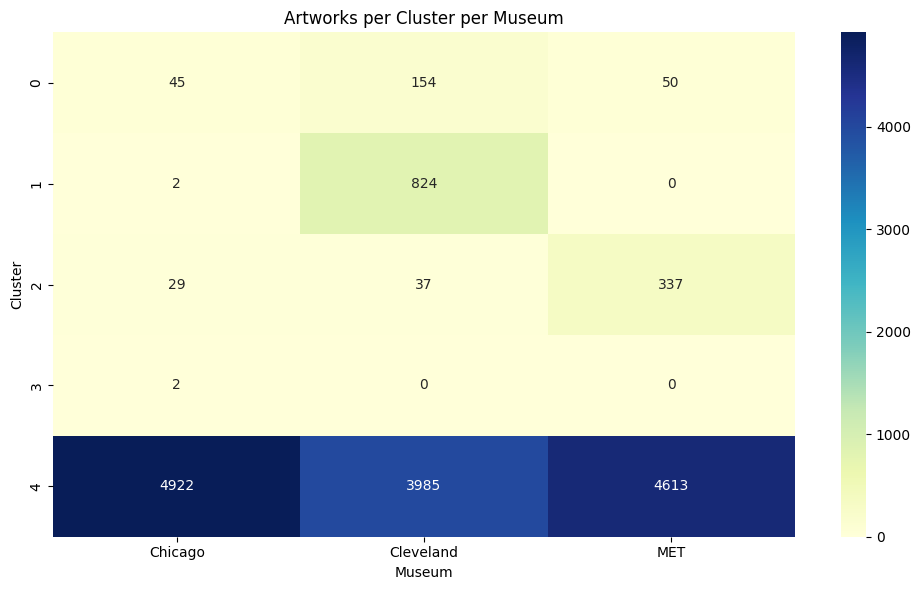

In [16]:
df = pd.concat([df_met, df_cleveland, df_chicago], ignore_index=True)

df = df.dropna(subset=['title'])

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
X = vectorizer.fit_transform(df['title'])

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

cluster_distribution = df.groupby(['cluster', 'source']).size().unstack(fill_value=0)

print("Cluster Distribution:")
print(cluster_distribution)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_distribution, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Artworks per Cluster per Museum")
plt.xlabel("Museum")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

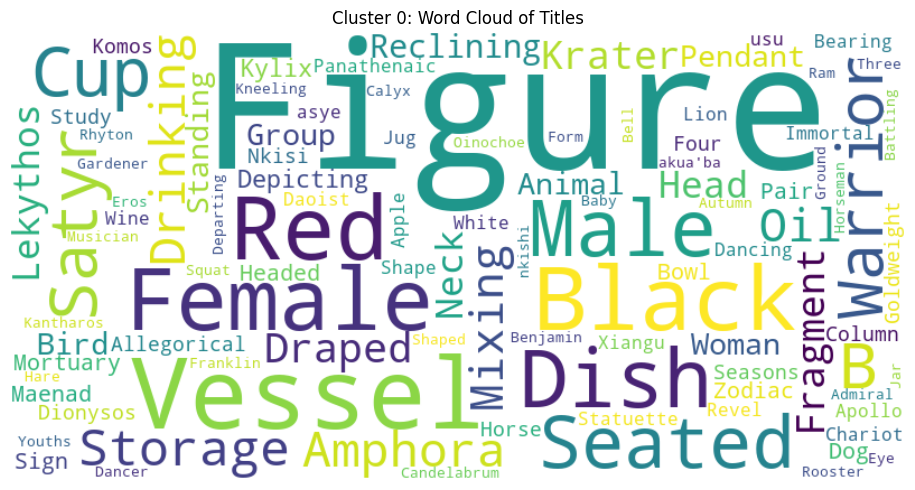

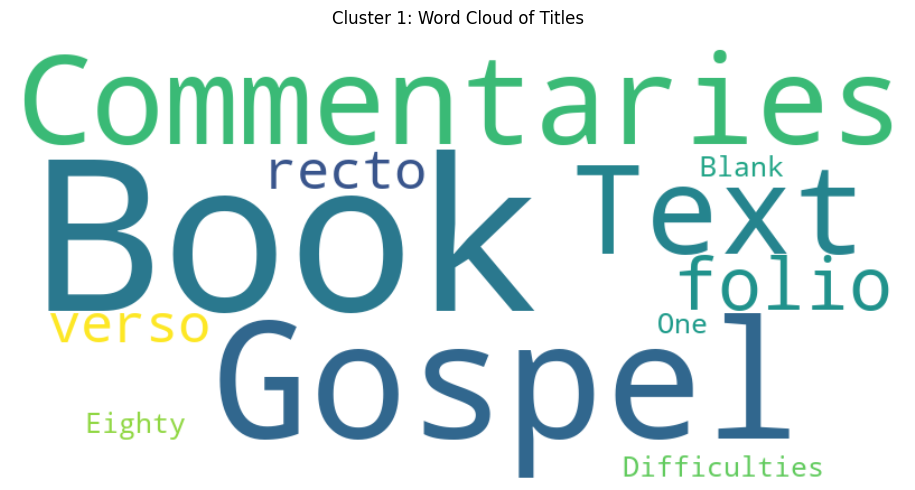

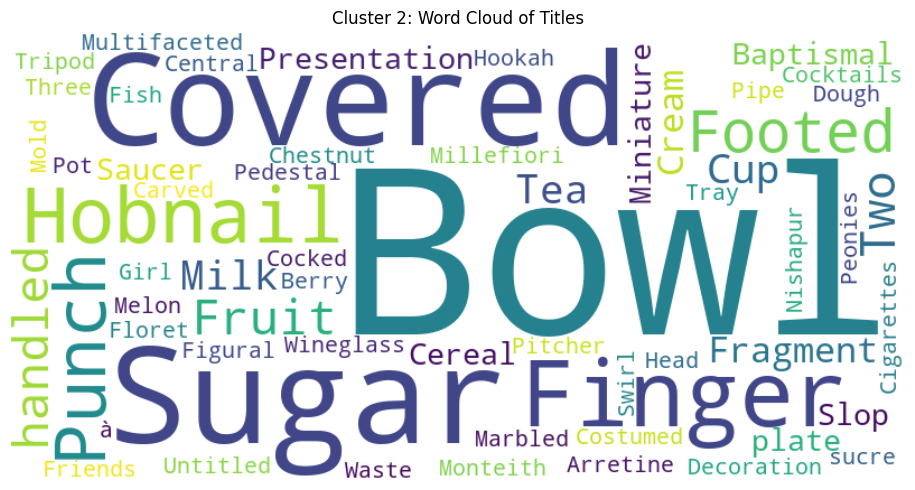

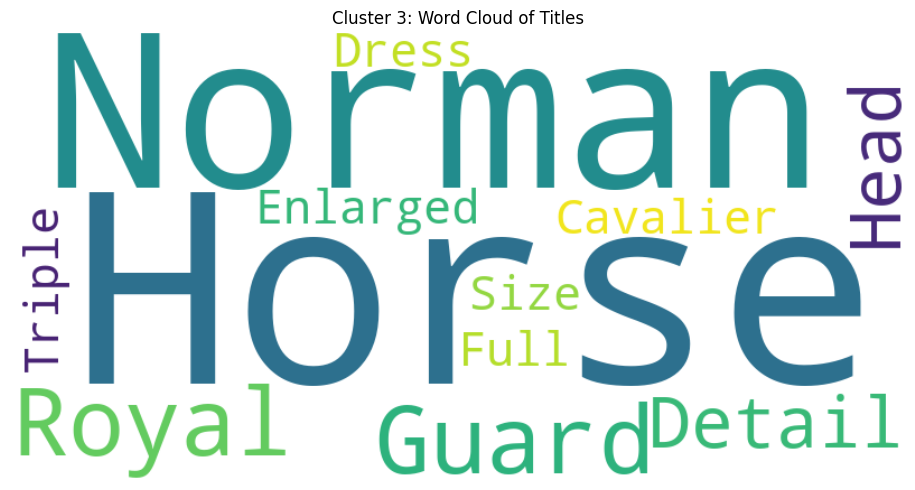

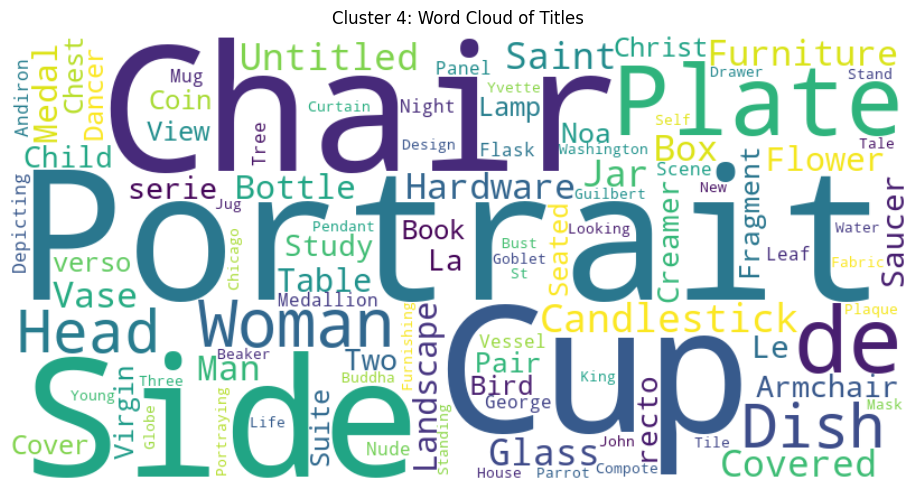

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['cluster'] = df['cluster'].astype(int)

for cluster_id in sorted(df['cluster'].unique()):
    titles = df[df['cluster'] == cluster_id]['title'].dropna().astype(str)
    text = " ".join(titles)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id}: Word Cloud of Titles")
    plt.tight_layout()
    plt.show()
